Objective:
To understand what factors contributed most to readmission within 30 days.
To perform clustering to find any meaningful patterns of patient information.
To create a model that predicts the likelihood if a certain patient will be readmitted or not.
To create or improve different strategies to avoid patient readmission within 30 days.

In [2]:
import IPython 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
from statistics import mode
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [3]:
df = pd.read_csv('diabetic_data.csv')

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
df.isnull().any()

encounter_id                False
patient_nbr                 False
race                        False
gender                      False
age                         False
weight                      False
admission_type_id           False
discharge_disposition_id    False
admission_source_id         False
time_in_hospital            False
payer_code                  False
medical_specialty           False
num_lab_procedures          False
num_procedures              False
num_medications             False
number_outpatient           False
number_emergency            False
number_inpatient            False
diag_1                      False
diag_2                      False
diag_3                      False
number_diagnoses            False
max_glu_serum               False
A1Cresult                   False
metformin                   False
repaglinide                 False
nateglinide                 False
chlorpropamide              False
glimepiride                 False
acetohexamide 

In [6]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [7]:
df.shape

(101766, 50)

In [8]:
dfcopy = df.copy()
missing = dfcopy.replace('?',np.NaN)
nacheck = missing.isnull().sum()
nacheck

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [9]:
dfcopy = dfcopy.drop(['weight','payer_code','medical_specialty'], axis = 1)

In [10]:
dfcopy['readmitted']

0          NO
1         >30
2          NO
3          NO
4          NO
5         >30
6          NO
7         >30
8          NO
9          NO
10        >30
11        <30
12        <30
13         NO
14        >30
15         NO
16        <30
17         NO
18        >30
19         NO
20         NO
21         NO
22         NO
23        >30
24         NO
25         NO
26         NO
27        >30
28        >30
29        >30
         ... 
101736    >30
101737     NO
101738     NO
101739     NO
101740     NO
101741     NO
101742     NO
101743     NO
101744     NO
101745     NO
101746    <30
101747    >30
101748    >30
101749     NO
101750    <30
101751     NO
101752     NO
101753     NO
101754    >30
101755    >30
101756    >30
101757     NO
101758     NO
101759     NO
101760    >30
101761    >30
101762     NO
101763     NO
101764     NO
101765     NO
Name: readmitted, Length: 101766, dtype: object

In [11]:
dfcopy['readmitted'] = dfcopy['readmitted'].replace('>30', 0)
dfcopy['readmitted'] = dfcopy['readmitted'].replace('<30', 1)
dfcopy['readmitted'] = dfcopy['readmitted'].replace('NO', 0)

In [12]:
dfcopy.groupby('readmitted').size()

readmitted
0    90409
1    11357
dtype: int64

In [13]:
dfcopy = dfcopy[((dfcopy.discharge_disposition_id != 11) & 
                                          (dfcopy.discharge_disposition_id != 13) &
                                          (dfcopy.discharge_disposition_id != 14) & 
                                          (dfcopy.discharge_disposition_id != 19) & 
                                          (dfcopy.discharge_disposition_id != 20) & 
                                          (dfcopy.discharge_disposition_id != 21))]


In [14]:
dfcopy.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,0
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,0
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,0


/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


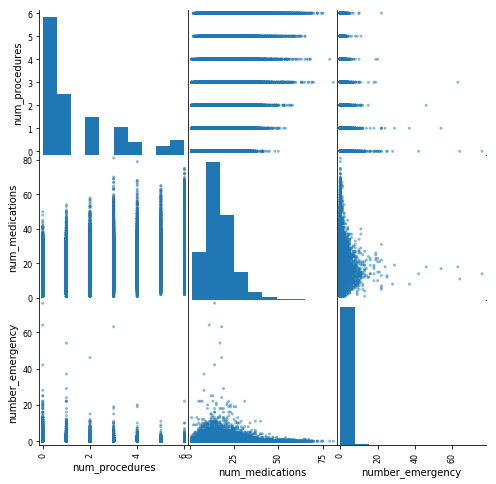

In [15]:
sm = pd.scatter_matrix(dfcopy[['num_procedures', 'num_medications', 'number_emergency']], figsize = (8, 8))
sns.despine()

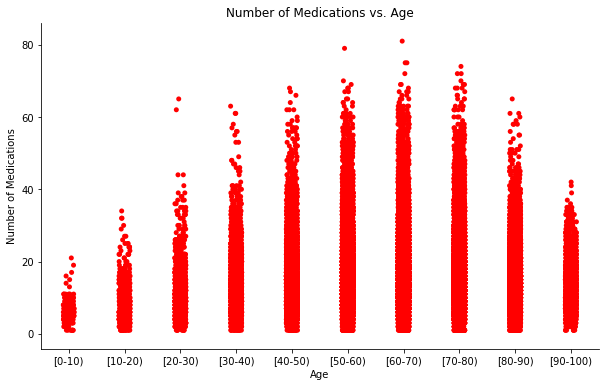

In [16]:
sortage = dfcopy.sort_values(by = 'age')
x = sns.stripplot(x = "age", y = "num_medications", data = sortage, color = 'red')
sns.despine() #remove top and right axes
x.figure.set_size_inches(10, 6)
x.set_xlabel('Age')
x.set_ylabel('Number of Medications')
x.axes.set_title('Number of Medications vs. Age')
plt.show()

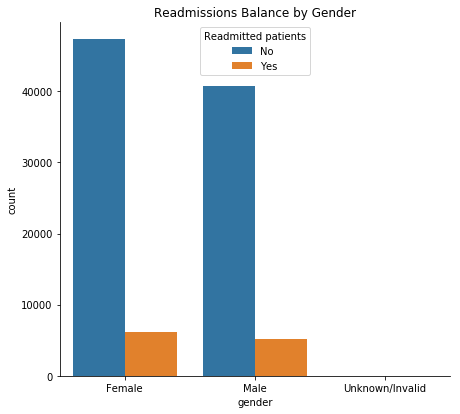

In [17]:
plot1 = sns.countplot(x = 'gender', hue = 'readmitted', data = dfcopy) 
sns.despine()
plot1.figure.set_size_inches(7, 6.5)
plot1.legend(title = 'Readmitted patients', labels = ('No', 'Yes'))
plot1.axes.set_title('Readmissions Balance by Gender')
plt.show()

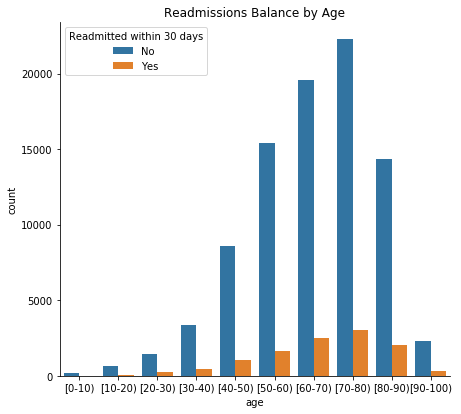

In [18]:
b = dfcopy.age.unique()
b.sort()
b_sort = np.array(b).tolist()


ageplt = sns.countplot(x = 'age', hue = 'readmitted', data = dfcopy, order = b_sort) 

sns.despine()
ageplt.figure.set_size_inches(7, 6.5)
ageplt.legend(title = 'Readmitted within 30 days', labels = ('No', 'Yes'))
ageplt.axes.set_title('Readmissions Balance by Age')
plt.show()

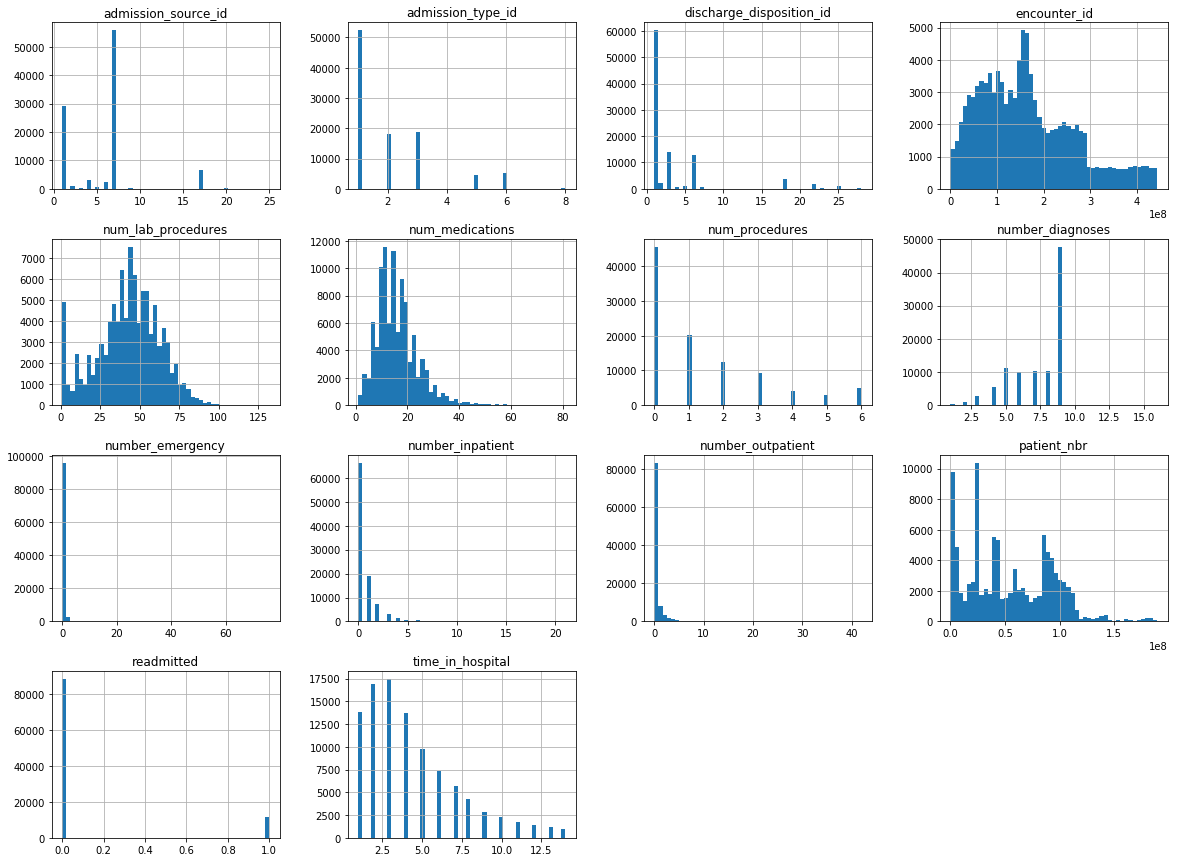

In [19]:
dfcopy.hist(bins=50, figsize=(20,15))
plt.show()

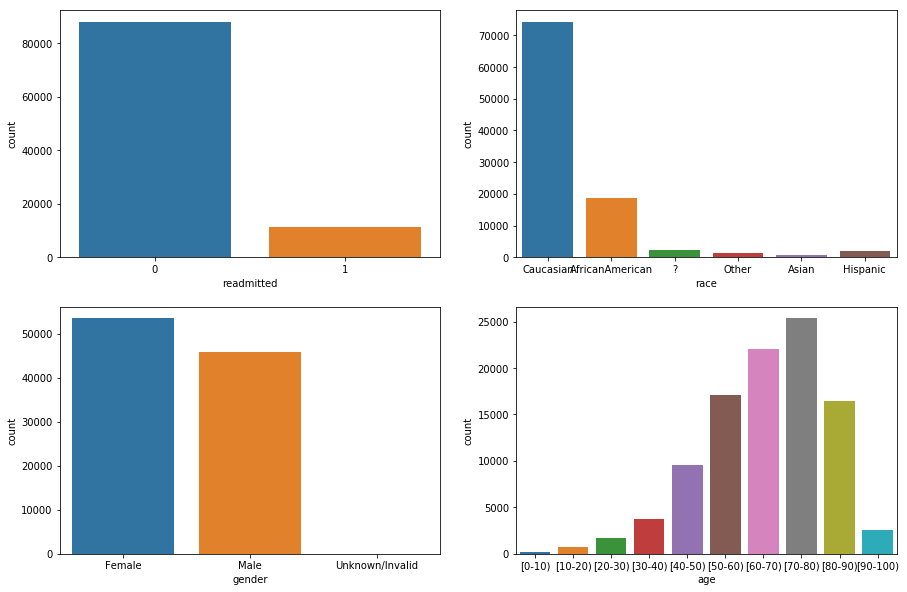

In [20]:
fig, ax = plt.subplots(figsize=(15,10), ncols=2, nrows=2)

sns.countplot(x="readmitted", data=dfcopy, ax=ax[0][0])
sns.countplot(x="race", data=dfcopy, ax=ax[0][1])
sns.countplot(x="gender", data=dfcopy, ax=ax[1][0])
sns.countplot(x="age", data=dfcopy, ax=ax[1][1])

In [21]:
numcolumn = dfcopy.select_dtypes(include = [np.number]).columns
objcolumn = dfcopy.select_dtypes(include = ['object']).columns

In [22]:
dfcopy[numcolumn] = dfcopy[numcolumn].fillna(0)
dfcopy[objcolumn] = dfcopy[objcolumn].fillna("unknown")

In [23]:
def map_now():
    listname = [('infections', 139),
                ('neoplasms', (239 - 139)),
                ('endocrine', (279 - 239)),
                ('blood', (289 - 279)),
                ('mental', (319 - 289)),
                ('nervous', (359 - 319)),
                ('sense', (389 - 359)),
                ('circulatory', (459-389)),
                ('respiratory', (519-459)),
                ('digestive', (579 - 519)),
                ('genitourinary', (629 - 579)),
                ('pregnancy', (679 - 629)),
                ('skin', (709 - 679)),
                ('musculoskeletal', (739 - 709)),
                ('congenital', (759 - 739)),
                ('perinatal', (779 - 759)),
                ('ill-defined', (799 - 779)),
                ('injury', (999 - 799))]
    
    
    dictcout = {}
    count = 1
    for name, num in listname:
        for i in range(num):
            dictcout.update({str(count): name})  
            count += 1
    return dictcout
  

    
  

def codemap(df, codes):
    import pandas as pd
    namecol = df.columns.tolist()
    for col in namecol:
        temp = [] 
        for num in df[col]:           
            if ((num is None) | (num in ['unknown', '?']) | (pd.isnull(num))): temp.append('unknown')
            elif(num.upper()[0] == 'V'): temp.append('supplemental')
            elif(num.upper()[0] == 'E'): temp.append('injury')
            else: 
                lkup = num.split('.')[0]
                temp.append(codes[lkup])           
        df.loc[:, col] = temp               
    return df 


listcol = ['diag_1', 'diag_2', 'diag_3']
codes = map_now()
dfcopy[listcol] = codemap(dfcopy[listcol], codes)
                

/Users/mac/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [24]:
dfcopy.describe

<bound method NDFrame.describe of         encounter_id  patient_nbr             race  gender       age  \
0            2278392      8222157        Caucasian  Female    [0-10)   
1             149190     55629189        Caucasian  Female   [10-20)   
2              64410     86047875  AfricanAmerican  Female   [20-30)   
3             500364     82442376        Caucasian    Male   [30-40)   
4              16680     42519267        Caucasian    Male   [40-50)   
5              35754     82637451        Caucasian    Male   [50-60)   
6              55842     84259809        Caucasian    Male   [60-70)   
7              63768    114882984        Caucasian    Male   [70-80)   
8              12522     48330783        Caucasian  Female   [80-90)   
9              15738     63555939        Caucasian  Female  [90-100)   
10             28236     89869032  AfricanAmerican  Female   [40-50)   
11             36900     77391171  AfricanAmerican    Male   [60-70)   
12             40926     85504

In [25]:
listnormal = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                     'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

from sklearn.preprocessing import StandardScaler

normal = StandardScaler()

dfcopy[listnormal] = normal.fit_transform(dfcopy[listnormal])

dfcopy.describe()

/Users/mac/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/mac/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,9.934300e+04,9.934300e+04,99343.000000,99343.000000,99343.000000,9.934300e+04,9.934300e+04,9.934300e+04,9.934300e+04,9.934300e+04,9.934300e+04,9.934300e+04,9.934300e+04,99343.000000
mean,1.649689e+08,5.426117e+07,2.030259,3.517882,5.731083,1.874346e-14,-3.424256e-15,3.449070e-15,-1.776343e-15,1.182191e-13,6.322393e-14,-1.499301e-15,-9.426101e-14,0.113888
std,1.026535e+08,3.873426e+07,1.446373,5.184359,4.065029,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,0.317677
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,-1.138438e+00,-2.137026e+00,-7.835647e-01,-1.850439e+00,-2.918627e-01,-2.116216e-01,-5.005746e-01,-3.298145e+00,0.000000
25%,8.469034e+07,2.338675e+07,1.000000,1.000000,1.000000,-8.015554e-01,-6.071886e-01,-7.835647e-01,-7.386238e-01,-2.918627e-01,-2.116216e-01,-5.005746e-01,-7.221572e-01,0.000000
50%,1.522321e+08,4.541774e+07,1.000000,1.000000,7.000000,-1.277904e-01,5.574070e-02,-1.962887e-01,-1.209485e-01,-2.918627e-01,-2.116216e-01,-5.005746e-01,3.082380e-01,0.000000
75%,2.301018e+08,8.756007e+07,3.000000,3.000000,7.000000,5.459746e-01,7.186700e-01,3.909872e-01,4.967267e-01,-2.918627e-01,-2.116216e-01,2.928105e-01,8.234355e-01,0.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,3.241035e+00,4.543262e+00,2.740091e+00,8.032365e+00,3.290615e+01,8.083523e+01,1.616051e+01,4.429819e+00,1.000000


In [26]:
y = dfcopy['readmitted']
X = dfcopy.drop(['readmitted'], axis =1)
X = pd.get_dummies(X)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, 
                                                random_state = 7, stratify = y)


In [28]:
print("shape of X_train,X_test:",X_train.shape,X_test.shape)

shape of X_train,X_test: (79474, 172) (19869, 172)


In [29]:
#import sys
#!pip install imblearn 

In [30]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=12, ratio = 1.0)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

In [31]:
print ("SMOTE sample shape:", X_train_sm.shape, y_train_sm.shape)

SMOTE sample shape: (140846, 172) (140846,)


In [32]:
# create model logistic as logistic regression using Sklearn 
from sklearn.linear_model import LogisticRegression
logisticreg = LogisticRegression(tol=1e-7, penalty='l2', C=0.0005)
logisticreg.fit(X_train_sm, y_train_sm)
ylog = logisticreg.predict(X_test)

/Users/mac/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
print(" The accuracy of the Logistic regression model:" ,logisticreg.score(X_test, y_test))

 The accuracy of the Logistic regression model: 0.5212139513815491


In [34]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, ylog))

[[9091 8515]
 [ 998 1265]]


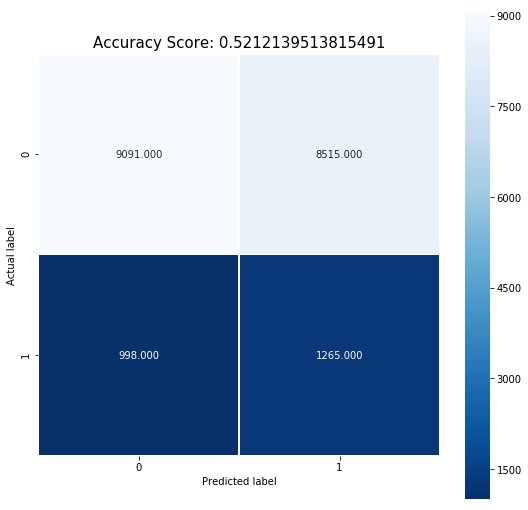

In [35]:
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix(y_test, ylog), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(logisticreg.score(X_test, y_test))
plt.title(all_sample_title, size = 15);

In [36]:
# Checking the summary of classification
from sklearn.metrics import classification_report
print(classification_report(y_test, ylog, target_names = ['NO', 'YES']))

              precision    recall  f1-score   support

          NO       0.90      0.52      0.66     17606
         YES       0.13      0.56      0.21      2263

   micro avg       0.52      0.52      0.52     19869
   macro avg       0.52      0.54      0.43     19869
weighted avg       0.81      0.52      0.61     19869



In [37]:
# Checking the performance of model using ROC curve plots
yScre = logisticreg.decision_function(X_test)

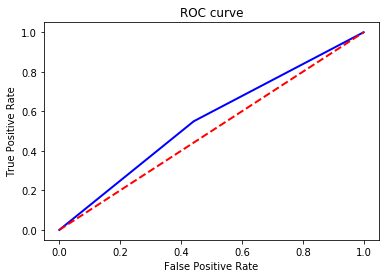

In [38]:
##Computing false and true positive rates
from sklearn.metrics import roc_curve

fpr, tpr,_=roc_curve(logisticreg.predict(X_train_sm),y_train_sm,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()
##Creating the ROC,
plt.plot(fpr, tpr, color='blue',
 lw=2, label='ROC curve')
##Finding FPR and TPR,
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
##Splecifying the label and title,
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=42,n_estimators=500)
random_forest.fit(X_train_sm, y_train_sm)
yrandforest = random_forest.predict(X_test)

In [40]:
#Calculating the score,
scorey =random_forest.predict_proba(X_test)[:,1]
rfpr, rtpr, thresholds = roc_curve(y_test, scorey)

In [41]:
print(" Accuracy of Randomeforest classification: ", random_forest.score(X_test, y_test))

 Accuracy of Randomeforest classification:  0.8864562886909255


In [42]:
print(confusion_matrix(y_test, yrandforest))

[[17599     7]
 [ 2249    14]]


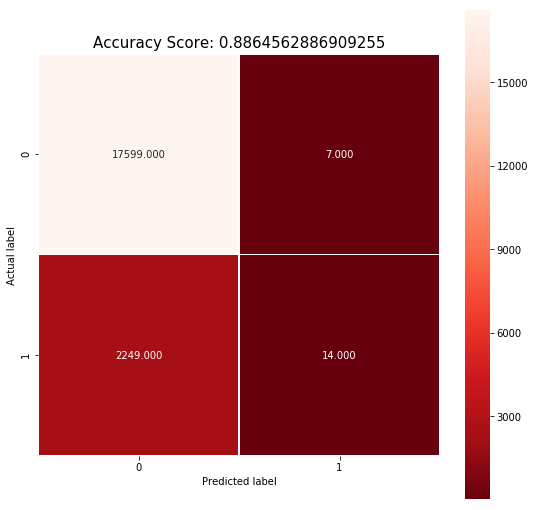

In [44]:
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix(y_test, yrandforest), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(random_forest.score(X_test, y_test))
plt.title(all_sample_title, size = 15);

In [45]:
print(classification_report(y_test, yrandforest, target_names = ['NO', 'YES']))

              precision    recall  f1-score   support

          NO       0.89      1.00      0.94     17606
         YES       0.67      0.01      0.01      2263

   micro avg       0.89      0.89      0.89     19869
   macro avg       0.78      0.50      0.48     19869
weighted avg       0.86      0.89      0.83     19869



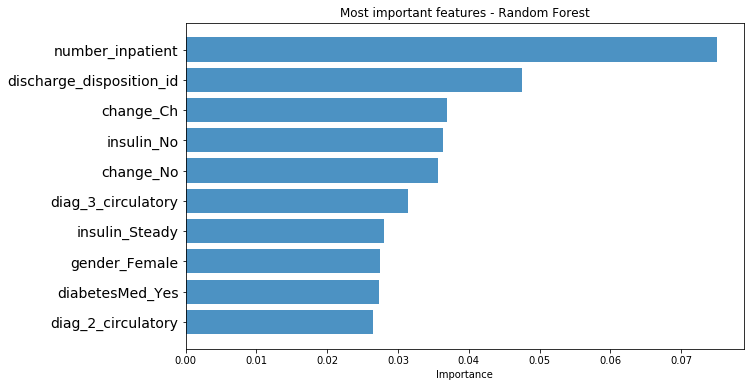

In [46]:
#Determining which features are most important,
feature_names = X_train.columns
feature_imports = random_forest.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest')
plt.show()

In [47]:
#Creating a AdaBoosted Classification model,
from sklearn.ensemble import AdaBoostClassifier
adaclass = AdaBoostClassifier(n_estimators = 20, learning_rate = 0.2, random_state = 123)
adaclass.fit(X_train, y_train)
yadaclas = adaclass.predict(X_test)

In [48]:
print("The accurary of AdaBoosted Classification model: ", adaclass.score(X_test, y_test))

The accurary of AdaBoosted Classification model:  0.8861039810760482


In [49]:
#Checking the confusion matrix,
print(confusion_matrix(y_test, yadaclas))

[[17606     0]
 [ 2263     0]]


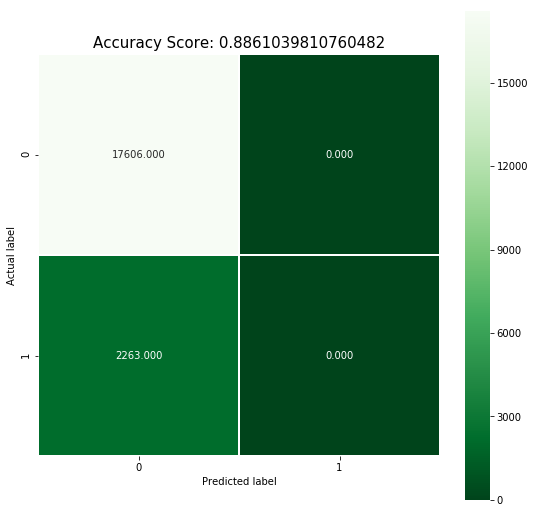

In [50]:
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix(y_test, yadaclas), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Greens_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(adaclass.score(X_test, y_test))
plt.title(all_sample_title, size = 15);

In [51]:
#Checking recall, f1 :-
print(classification_report(y_test, yadaclas, target_names = ['NO', 'YES']))

              precision    recall  f1-score   support

          NO       0.89      1.00      0.94     17606
         YES       0.00      0.00      0.00      2263

   micro avg       0.89      0.89      0.89     19869
   macro avg       0.44      0.50      0.47     19869
weighted avg       0.79      0.89      0.83     19869



/Users/mac/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mac/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mac/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
# calculate the False Positive and True Positive rate to get the ROC curve  
yadaclas = adaclass.decision_function(X_test)
fpr_adaclass, tpr_adaclass, thresholds = roc_curve(y_test, yadaclas)

In [53]:
# Doing parameter tuning,
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

ada_boost = AdaBoostClassifier(n_estimators = 20, learning_rate = 0.2, random_state = 123)
gridparam ={
        'n_estimators': [100, 200,500],
        'learning_rate': [0.2,0.5,1.0],
},
adagrid = GridSearchCV(ada_boost, cv=3, n_jobs=3, param_grid=gridparam)
adagrid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.2, n_estimators=20, random_state=123),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid=({'n_estimators': [100, 200, 500], 'learning_rate': [0.2, 0.5, 1.0]},),
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [54]:
#The accuracy of the model with the best parameters
adagrid.score(X_test, y_test)

0.8860536514167799

In [55]:
gridyada = adagrid.predict(X_test)
print(classification_report(y_test, gridyada, target_names = ['NO', 'YES']))

              precision    recall  f1-score   support

          NO       0.89      1.00      0.94     17606
         YES       0.43      0.00      0.00      2263

   micro avg       0.89      0.89      0.89     19869
   macro avg       0.66      0.50      0.47     19869
weighted avg       0.83      0.89      0.83     19869



In [56]:
ygridadascore = adagrid.decision_function(X_test)
fpr_adamod, tpr_adamod, thresholds_grid_ada = roc_curve(y_test, ygridadascore)

In [58]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

In [59]:
clfgini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clfgini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [60]:
ypreddt = clfgini.predict(X_test)
ypreddt

array([0, 0, 0, ..., 0, 0, 0])

In [61]:
print( "Accuracy is ", accuracy_score(y_test,ypreddt)*100)

Accuracy is  88.61039810760481


In [63]:
fpr_log, tpr_log, thresholds = roc_curve(y_test, yScre)#logistic regression
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, yrandforest)#random forest classifier
fpr_adaclf, tpr_adaclf, thresholds = roc_curve(y_test, yadaclas)#Ada boost classifier
fpr_adamod, tpr_adamod, thresholds = roc_curve(y_test,ygridadascore )#Hyperparameters Tunning for AdaBoosted
fpr_dt, tpr_dt, thresholds = roc_curve(y_test,ypreddt )

/Users/mac/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'True Positive Rate')

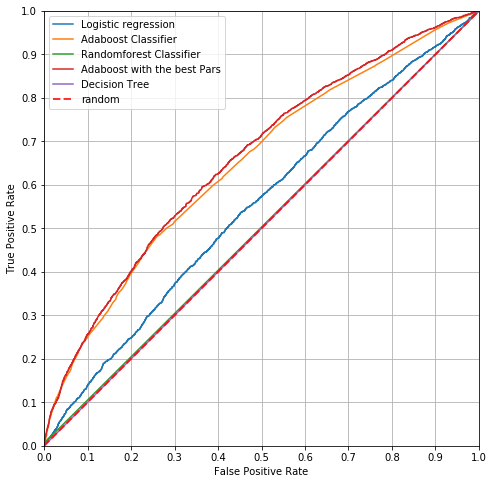

In [64]:
#compare the ROC curve between different models
plt.figure(figsize=(8,8))
plt.plot(fpr_log, tpr_log, label='Logistic regression')
plt.plot(fpr_adaclf, tpr_adaclf, label='Adaboost Classifier')
plt.plot(fpr_rf, tpr_rf, label='Randomforest Classifier')
plt.plot(fpr_adamod, tpr_adamod, label='Adaboost with the best Pars')
plt.plot(fpr_dt, tpr_dt, label='Decision Tree')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='random', alpha=.8)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.legend()
plt.axes().set_aspect('equal')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [65]:
print(" Accuracy of Logistic regression model:" ,logisticreg.score(X_test, y_test)*100)
print("Accuracy of Random forest classification: ", random_forest.score(X_test, y_test)*100)
print("Accuracy of AdaBoosted Classification model: ", adaclass.score(X_test, y_test)*100)
print("Accuracy of Hyperparameter Tuning AdaBoosted Classification model: ", adagrid.score(X_test, y_test)*100)
print( "Accuracy of Decision Tree ", accuracy_score(y_test,ypreddt)*100)

 Accuracy of Logistic regression model: 52.12139513815492
Accuracy of Random forest classification:  88.64562886909255
Accuracy of AdaBoosted Classification model:  88.61039810760481
Accuracy of Hyperparameter Tuning AdaBoosted Classification model:  88.60536514167799
Accuracy of Decision Tree  88.61039810760481
